In [26]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from utils import *

EXP_NAME = "Logistic Regression"
EPOCHS = 10

## Read Dataset from CSV file

CSV file is modified to have columns as follows:

- sentence: original sentence
- label : class (0 to 4)
- tokens : tokenized sentence
- score : sentiment score (0 to 1)


In [27]:
train_df = pd.read_csv("dataset/train.csv")
print("Train size: ", len(train_df))

val_df = pd.read_csv("dataset/val.csv")
print("Val size  : ", len(val_df))

test_df = pd.read_csv("dataset/test.csv")
print("Test size : ", len(test_df))

Train size:  8544
Val size  :  1101
Test size :  2210


## Classes Distribution


Train class distribution:
label
0    1092
1    2218
2    1624
3    2322
4    1288
Name: count, dtype: int64
Val class distribution:
label
0    139
1    289
2    229
3    279
4    165
Name: count, dtype: int64
Test class distribution:
label
0    279
1    633
2    389
3    510
4    399
Name: count, dtype: int64


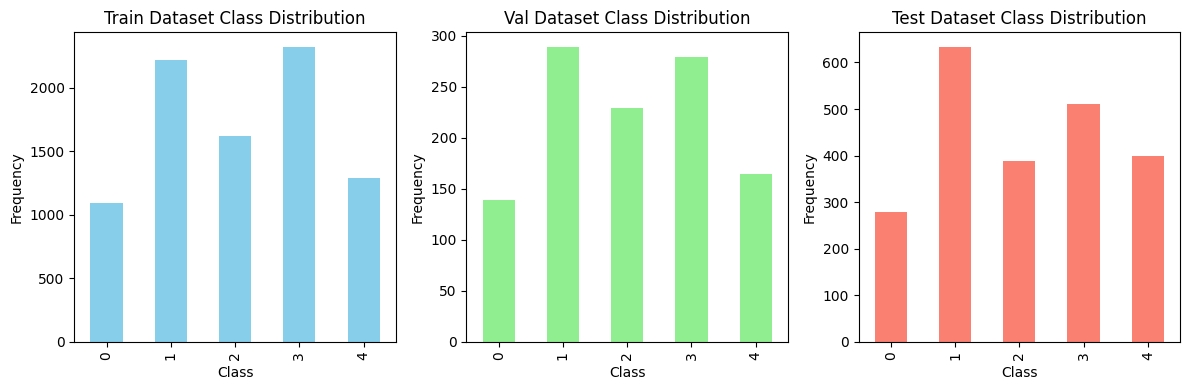

In [28]:
print("Train class distribution:")
print(train_df.label.value_counts().sort_index())

print("Val class distribution:")
print(val_df.label.value_counts().sort_index())

print("Test class distribution:")
print(test_df.label.value_counts().sort_index())

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
train_df["label"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Train Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
val_df["label"].value_counts().sort_index().plot(kind="bar", color="lightgreen")
plt.title("Val Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
test_df["label"].value_counts().sort_index().plot(kind="bar", color="salmon")
plt.title("Test Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Tokenization


In [29]:
def tokenize(tokens):
    return tokens.lower().split()

In [30]:
print("Sentence:")
print(train_df.iloc[3]["sentence"])

print("\nSentence Tokenized:")
tokens = tokenize(train_df.iloc[3]["sentence"])
print(tokens)

Sentence:
You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .

Sentence Tokenized:
['you', "'d", 'think', 'by', 'now', 'america', 'would', 'have', 'had', 'enough', 'of', 'plucky', 'british', 'eccentrics', 'with', 'hearts', 'of', 'gold', '.']


## Bigrams


In [31]:
def extract_bigrams(sentence):
    words = tokenize(sentence)
    return [(words[i], words[i + 1]) for i in range(len(words) - 1)]

## Feature Matrix for Train dataset

using int8 instead of float64 to save memory


In [32]:
def generate_train_features(dataframe):
    unique_bigrams = set()
    for _, sample in dataframe.iterrows():
        sample_bigrams = extract_bigrams(sample["sentence"])
        unique_bigrams.update(sample_bigrams)

    bigrams_indices = {bi_gram: index for index, bi_gram in enumerate(unique_bigrams)}

    feature_matrix = np.zeros((len(dataframe), len(unique_bigrams))).astype(np.int8)

    for i, (_, sample) in enumerate(dataframe.iterrows()):
        sample_bigrams = extract_bigrams(sample["sentence"])
        for b in sample_bigrams:
            index = bigrams_indices.get(b)
            if index is not None:
                feature_matrix[i, index] = 1

    return feature_matrix, bigrams_indices

In [33]:
train_feature_matrix, train_bigrams_indices = generate_train_features(train_df)
print(
    "Train Feature matrix shape (samples x unique bigrams):", train_feature_matrix.shape
)
print("Train Feature matrix datatype:", train_feature_matrix.dtype)

Train Feature matrix shape (samples x unique bigrams): (8544, 84518)
Train Feature matrix datatype: int8


## Unify features for val & test set

Remove all Features (bigrams) from val & test set that doesn't appear in training features


In [34]:
def filter_features(dataframe):
    unique_dataframe_bigrams = set()
    for _, sample in dataframe.iterrows():
        sample_bigrams = extract_bigrams(sample["sentence"])
        unique_dataframe_bigrams.update(sample_bigrams)

    unique_train_bigrams = set(train_bigrams_indices.keys())
    common_bigrams = unique_dataframe_bigrams.intersection(unique_train_bigrams)
    feature_matrix = np.zeros((len(dataframe), len(train_bigrams_indices))).astype(
        np.int8
    )

    for i, (_, sample) in enumerate(dataframe.iterrows()):
        sample_bigrams = extract_bigrams(sample["sentence"])
        for b in sample_bigrams:
            if b in common_bigrams:
                index = train_bigrams_indices.get(b)
                feature_matrix[i, index] = 1

    return feature_matrix

In [35]:
val_feature_matrix = filter_features(val_df)
print("Val Feature matrix shape (samples x unique bigrams):", val_feature_matrix.shape)

test_feature_matrix = filter_features(test_df)
print(
    "\nTest Feature matrix shape (samples x unique bigrams):",
    test_feature_matrix.shape,
)

Val Feature matrix shape (samples x unique bigrams): (1101, 84518)

Test Feature matrix shape (samples x unique bigrams): (2210, 84518)


## Model Implementation


In [36]:
X_train = train_feature_matrix
y_train = train_df.label.values

X_val = val_feature_matrix
y_val = val_df.label.values

X_test = test_feature_matrix
y_test = test_df.label.values

#### Comet Logger

In [37]:
experiment = Experiment(
    api_key="rwyMmTQC0QDIH0oF5XaSzgmh4",
    project_name="nlp-lr",
    workspace="youssefaboelwafa",
)
experiment.set_name(EXP_NAME)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 10 epochs
COMET INFO:     url                   : https://www.comet.com/youssefaboelwafa/nlp-lr/6c73fbf397964c55b42bcf17fc47da6a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [20] : (0.12780898876404495, 0.2744616104868914)
COMET INFO:     train_loss [20]     : (1.593871393370048, 1.6094379425048828)
COMET INFO:     val_accuracy        : 0.25340599455040874
COMET INFO:     val_loss [20]       : (1.5951361999416438, 1.6077157855575244)
COMET INFO:   Others:
COMET INFO:     Name : 10 epochs
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     

### Training & Validation


In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


class LR:
    def __init__(self, num_classes=5, epochs=100, learning_rate=0.01):
        self.num_classes = num_classes
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_samples, n_features = X_train.shape
        n_classes = self.num_classes

        self.weights = np.zeros((n_features, n_classes)).astype(np.float32)
        self.bias = np.zeros(n_classes).astype(np.float32)

        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")

            logits = X_train @ self.weights + self.bias
            probabilities = softmax(logits)

            output_hot_encoded = np.eye(n_classes)[y_train]

            error = probabilities - output_hot_encoded

            train_loss = (
                -np.sum(output_hot_encoded * np.log(probabilities + 1e-15)) / n_samples
            )

            train_preds = np.argmax(probabilities, axis=1)
            train_accuracy = np.mean(train_preds == y_train)

            experiment.log_metric("train_loss", train_loss, step=epoch)
            experiment.log_metric("train_accuracy", train_accuracy, step=epoch)

            dw = (1 / n_samples) * np.dot(X_train.T, error)
            db = (1 / n_samples) * np.sum(error, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if X_val is not None and y_val is not None:
                val_logits = X_val @ self.weights + self.bias
                val_probabilities = softmax(val_logits)
                val_output_hot_encoded = np.eye(n_classes)[y_val]

                val_loss = (
                    -np.sum(val_output_hot_encoded * np.log(val_probabilities + 1e-15))
                    / X_val.shape[0]
                )
                val_preds = np.argmax(val_probabilities, axis=1)
                val_accuracy = np.mean(val_preds == y_val)

                experiment.log_metric("val_loss", val_loss, step=epoch)
                experiment.log_metric("val_accuracy", val_accuracy, step=epoch)

        print("Training completed")
        print("Train loss: ", train_loss)
        print("Train accuracy: ", train_accuracy)
        if X_val is not None and y_val is not None:
            print("Val loss: ", val_loss)
            print("Val accuracy: ", val_accuracy)

    def predict(self, X):
        scores = np.dot(X, self.weights) + self.bias
        probabilities = softmax(scores)
        preds = np.argmax(probabilities, axis=1)
        return preds

    def save_weights(self, weights_path, bias_path):
        np.save(weights_path, self.weights)
        np.save(bias_path, self.bias)

    def load_weights(self, weights_path, bias_path):
        self.weights = np.load(weights_path)
        self.bias = np.load(bias_path)

In [ ]:
model = LR(num_classes=5, epochs=EPOCHS, learning_rate=0.05)
# model.fit(X_train, y_train, X_val, y_val)
model.load_weights("weights.npy", "bias.npy")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Training completed
Train loss:  5.084209666646472
Train accuracy:  0.20985486891385768
Val loss:  3.989888218172472
Val accuracy:  0.21435059037238874


### Inference


In [51]:
y_pred = model.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.19909502262443438


### Classification Report

In [52]:
results = classification_report(y_test, y_pred, target_names=["0", "1", "2", "3", "4"])
print(results)

              precision    recall  f1-score   support

           0       0.14      0.11      0.12       279
           1       0.29      0.13      0.18       633
           2       0.17      0.32      0.22       389
           3       0.24      0.26      0.25       510
           4       0.18      0.18      0.18       399

    accuracy                           0.20      2210
   macro avg       0.20      0.20      0.19      2210
weighted avg       0.22      0.20      0.19      2210



## Scikit-learn


### Logistic Regression


In [ ]:
logistic_model = LogisticRegression(max_iter=EPOCHS)

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy : ", test_accuracy)

/home/youssef/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy:  0.8087546816479401
Test Accuracy :  0.3380090497737557


#### Classification Report

In [ ]:
results = classification_report(y_test, y_pred, target_names=["0", "1", "2", "3", "4"])
print(results)

              precision    recall  f1-score   support

           0       0.33      0.09      0.14       279
           1       0.40      0.52      0.46       633
           2       0.18      0.16      0.17       389
           3       0.35      0.54      0.42       510
           4       0.53      0.23      0.32       399

    accuracy                           0.36      2210
   macro avg       0.36      0.31      0.30      2210
weighted avg       0.36      0.36      0.33      2210



### Stochastic Gradient Descent


In [ ]:
sgd_sklearn = SGDClassifier(
    loss="log_loss", max_iter=EPOCHS, learning_rate="constant", eta0=0.05, shuffle=True
)

sgd_sklearn.fit(X_train, y_train)

y_pred = sgd_sklearn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy : ", test_accuracy)

/home/youssef/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Train Accuracy:  0.9881788389513109
Test Accuracy :  0.3561085972850679


#### Classification Report

In [ ]:
results = classification_report(y_test, y_pred, target_names=["0", "1", "2", "3", "4"])
print(results)

              precision    recall  f1-score   support

           0       0.33      0.09      0.14       279
           1       0.40      0.52      0.46       633
           2       0.18      0.16      0.17       389
           3       0.35      0.54      0.42       510
           4       0.53      0.23      0.32       399

    accuracy                           0.36      2210
   macro avg       0.36      0.31      0.30      2210
weighted avg       0.36      0.36      0.33      2210

